Here we want to experiment with getting a similar random forest model running. Then we need to develop a pipeline for a feature selection process. Then finally we need to have a process set up to try different machine learning architectures for tabular datasets (and hyperparameter tuning included).

In [1]:
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

/Users/hamishcampbell/opt/miniconda3/envs/geospatial/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import wandb

In [3]:
# load in the dataset
df = pd.read_csv('depth_dataset.csv', index_col='system:index')
df

,date,CROPTYPE,d2_River,AV_STK_100,REdge1,REdge2,REdge3,NDVI,REdge4,Landcover,...,partner,AV_STK_150,MRVBF,NDMI,NIR,Landcover_conf,location,Green,SWIR1,SWIR2
system:index,,,,,,,,,,,,,,,,,,,,,
0,1981,1,89.442719,9.260000,1320.250000,3458.250000,4190.500000,0.691862,4310.250000,3,...,LandIS - LPS,5.490000,6,0.325315,4448.750000,100,Various,879.000000,2264.750000,1560.250000
1,1985,10,1722.353027,27.110001,849.333333,2879.666667,3934.666667,0.867142,4204.000000,3,...,LandIS - LPS,11.070000,6,0.444473,4628.333333,91,Various,521.333333,1780.000000,999.000000
2,1985,2,2098.046631,27.110001,1190.750000,2690.000000,3501.750000,0.674522,3756.500000,3,...,LandIS - LPS,11.070000,6,0.245113,3766.000000,45,Various,775.000000,2283.250000,1531.000000
3,1985,16,1241.490967,27.110001,537.250000,2362.250000,3552.250000,0.881631,3749.000000,3,...,LandIS - LPS,11.070000,6,0.556354,3680.000000,78,Various,374.750000,1049.000000,480.500000
4,1979,25,784.346863,27.110001,1260.750000,2444.750000,2778.750000,0.595938,2980.500000,3,...,LandIS - LPS,11.070000,6,0.143434,3045.250000,95,Various,811.750000,2281.250000,1630.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,1986,6,353.553406,81.459999,1212.473684,3595.184211,4685.236842,0.818177,4970.342105,3,...,LandIS - LPS,45.310001,6,0.507083,5064.315789,45,Various,840.868421,1656.368421,816.052632
1283,1982,25,356.089844,81.459999,1016.741935,1532.774194,1748.451613,0.436547,2051.096774,3,...,LandIS - LPS,45.310001,6,-0.161179,1985.354839,92,Various,674.806452,2748.322581,2231.967742
1284,1982,9,750.000000,14.150000,736.241379,2316.827586,3185.965517,0.803224,3453.034483,3,...,LandIS - LPS,6.000000,6,0.429462,3336.586207,84,Various,507.931034,1331.724138,698.931034


In [4]:
# get the feature names from the column headings 
feature_names = [i for i in df.columns]
feature_names.remove('depth')
feature_names.remove('partner')
feature_names.remove('location')

In [5]:
# Lets try taking just test data = Burwell Fen data 
test_df = df.loc[df['location'] == 'Burwell Fen']
x_test = test_df.drop(['depth','partner','location'], axis=1)
y_test = test_df['depth']

In [6]:
test_df

,date,CROPTYPE,d2_River,AV_STK_100,REdge1,REdge2,REdge3,NDVI,REdge4,Landcover,...,partner,AV_STK_150,MRVBF,NDMI,NIR,Landcover_conf,location,Green,SWIR1,SWIR2
system:index,,,,,,,,,,,,,,,,,,,,,
1023,2022,17,60.827629,81.459999,1089.687500,3338.968750,4174.156250,0.831684,4505.812500,4,...,National Trust,45.310001,6,0.361467,4533.875000,86,Burwell Fen,647.781250,2126.406250,1049.906250
1024,2022,29,60.000000,20.490000,1107.083333,3749.361111,4656.277778,0.852354,4990.972222,4,...,National Trust,9.000000,6,0.435429,5343.861111,78,Burwell Fen,705.222222,2101.805556,1028.222222
1025,2022,21,70.000000,20.490000,1446.388889,3402.055556,4006.055556,0.737874,4378.305556,4,...,National Trust,9.000000,6,0.240108,4376.666667,54,Burwell Fen,888.416667,2681.861111,1422.555556
1026,2022,21,70.000000,20.490000,1359.171429,3238.457143,3837.114286,0.745677,4218.628571,4,...,National Trust,9.000000,6,0.241929,4098.400000,73,Burwell Fen,807.171429,2501.657143,1287.314286
1028,2022,1,31.622776,20.490000,1257.235294,3138.470588,3779.029412,0.745438,4186.500000,4,...,National Trust,9.000000,6,0.279229,3927.441176,45,Burwell Fen,735.970588,2212.882353,1151.588235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173,2022,31,391.152161,81.459999,1301.058824,3229.823529,3873.470588,0.784062,4216.470588,4,...,National Trust,45.310001,6,0.273156,4173.235294,72,Burwell Fen,734.617647,2382.500000,1308.029412
1174,2022,31,313.847107,81.459999,1381.352941,3298.441176,3885.205882,0.736461,4287.558824,4,...,National Trust,45.310001,6,0.259564,4312.117647,64,Burwell Fen,852.941176,2534.882353,1358.411765
1175,2022,31,224.722046,81.459999,1282.625000,3226.906250,3872.468750,0.786124,4243.906250,4,...,National Trust,45.310001,6,0.301877,4109.843750,79,Burwell Fen,707.937500,2203.875000,1152.656250


In [7]:
# use everything else as the training set
df = df.loc[df['location'] != 'Burwell Fen']

# split randomly into training and testing 
splits_train_val = RandomSplitter(valid_pct=0.2, seed=10)(df)

# for some models we need explicit datasets
x_train = df.iloc[splits_train_val[0],:].drop(['depth','partner','location'], axis=1)
y_train = df.iloc[splits_train_val[0],:]['depth']

x_val = df.iloc[splits_train_val[1],:].drop(['depth','partner','location'], axis=1)
y_val = df.iloc[splits_train_val[1],:]['depth']

In [8]:
x_train

,date,CROPTYPE,d2_River,AV_STK_100,REdge1,REdge2,REdge3,NDVI,REdge4,Landcover,...,Soiltype,d2_Watercourse,AV_STK_150,MRVBF,NDMI,NIR,Landcover_conf,Green,SWIR1,SWIR2
system:index,,,,,,,,,,,,,,,,,,,,,
1179,1986,2,518.652100,20.490000,748.700000,2770.066667,3903.800000,0.855907,4195.466667,3,...,54,50.000000,9.000000,6,0.505244,4159.366667,75,498.300000,1367.133333,650.300000
339,1984,7,424.264069,76.379997,630.666667,2706.000000,3952.333333,0.897026,4125.000000,3,...,2,169.705627,45.919998,6,0.566244,4157.333333,63,397.333333,1151.333333,527.666667
624,2021,17,2390.690430,27.110001,910.285714,2853.928571,3943.857143,0.833147,4173.214286,3,...,51,20.000000,11.070000,6,0.491527,4448.000000,55,626.428571,1516.357143,833.857143
482,1985,7,240.000000,75.339996,1155.000000,2444.071429,3023.785714,0.608147,3252.071429,8,...,3,76.157730,45.310001,6,0.264028,3265.571429,97,798.428571,1901.357143,1117.000000
152,1979,16,1900.315674,27.110001,1059.000000,1732.333333,1922.666667,0.404963,2035.666667,3,...,51,56.568542,11.070000,6,0.019997,1972.333333,91,753.333333,1895.000000,1541.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,1980,16,956.033447,12.900000,1267.125000,1469.625000,1608.375000,0.252484,1819.875000,3,...,52,128.062485,2.680000,6,-0.183744,1772.500000,91,819.625000,2570.500000,2231.500000
389,1985,12,438.292114,73.970001,797.466667,1982.200000,2268.666667,0.726127,2405.133333,3,...,1,36.055511,47.040001,6,0.140352,2324.000000,65,516.000000,1751.933333,1297.000000
987,2022,21,590.931458,86.190002,1207.346154,2739.576923,3204.576923,0.661771,3495.423077,8,...,3,22.360680,47.299999,6,0.177986,3061.653846,92,690.807692,2136.461538,1212.884615


# Data Exploration

In [9]:
# plot the distribution of each predictor (some methods want normally distrbuted not long tail e.g.)
#df.hist(feature_names);

/var/folders/_2/8l2kmjbx1hx91gnsycyn7ypw0000gn/T/ipykernel_13038/949130097.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df.corr(), fignum=f.number)


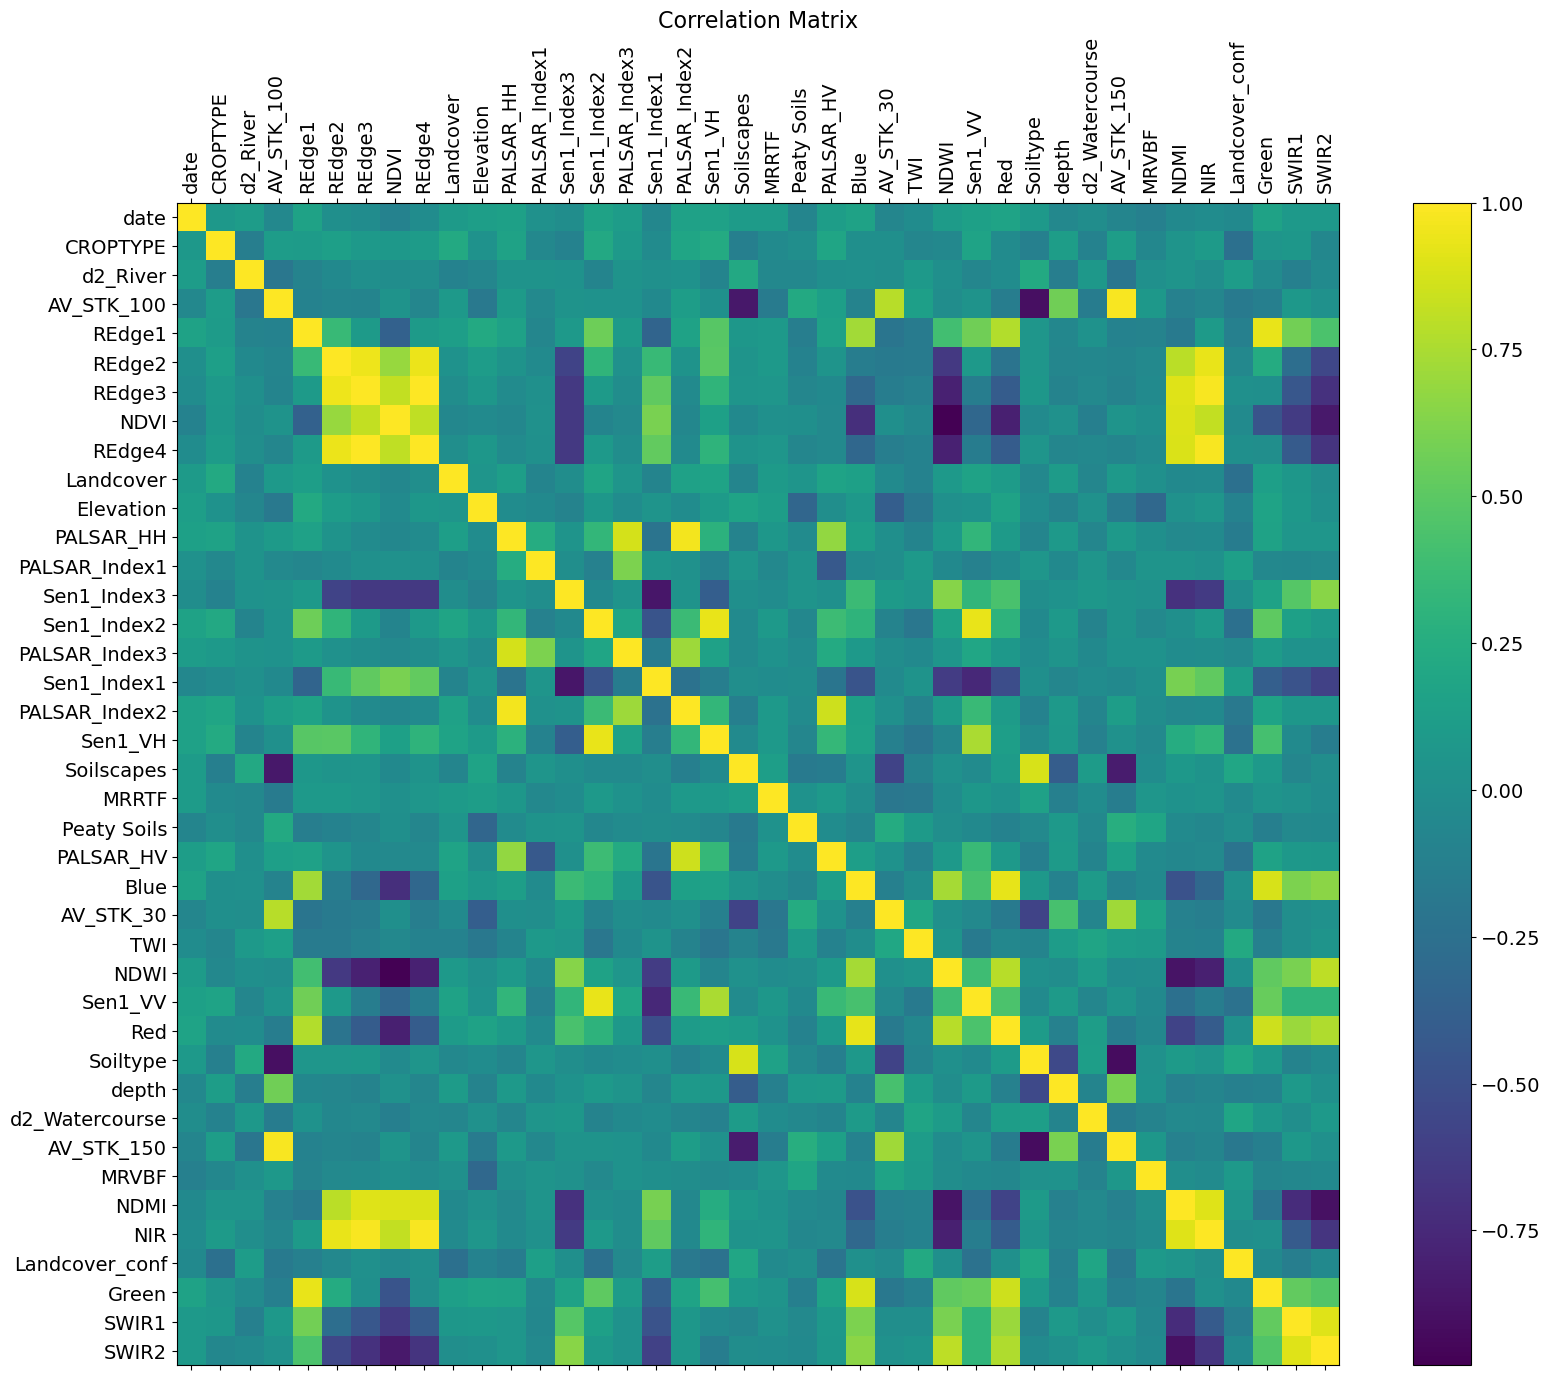

In [10]:
# plot the correlation matrix between all the predictors 
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

# Random Forest

In [11]:
# instantiate the random forest regressor object
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 1, oob_score=True)
 
# fit the random forest to the x and y data (for random forest don't need validation set)
rf_model.fit(pd.concat([x_train, x_val]), pd.concat([y_train, y_val])) 

RandomForestRegressor(oob_score=True, random_state=1)

In [12]:
# look at the feature importances for the model
importances = rf_model.feature_importances_

# place them in a pandas object and re-organise them
forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values().iloc[::-1]

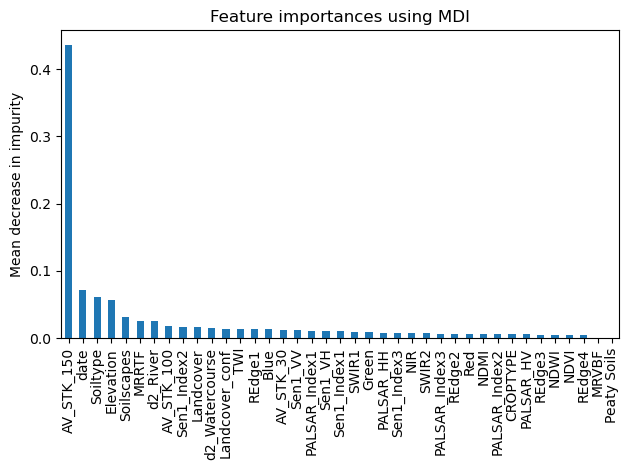

In [13]:
# plot the feature importances 
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [14]:
y_pred_train_val = rf_model.predict(pd.concat([x_train, x_val]))
y_pred_test = rf_model.predict(x_test)

In [15]:
# Out of bag error is the average error given by trees on datapoints not used to train those trees? score?
print("Out of bag error:")
print(rf_model.oob_score_)

Out of bag error:
0.6528438870290241


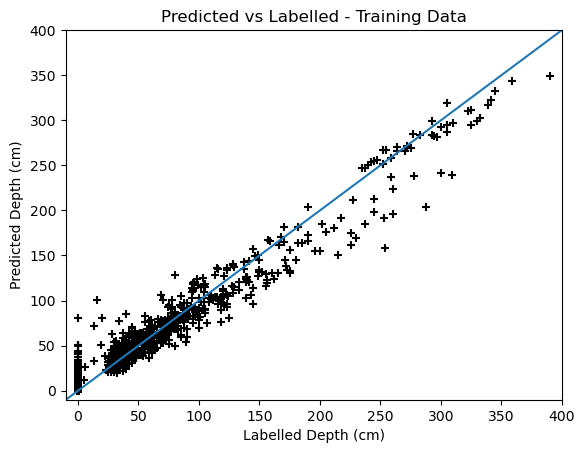

In [16]:
# add a scatter plot of the data points
plt.scatter(pd.concat([y_train, y_val]), y_pred_train_val, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Training Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400]);

In [17]:
# calculate the R-Squared and RMSE error to model evaluation
true_values = pd.concat([y_train, y_val])
predictions = y_pred_train_val

R_squared = r2_score(true_values, predictions)
print("R Squared:", R_squared)

RMSE = mean_squared_error(pd.concat([y_train, y_val]), y_pred_train_val, squared=False)
print("RMSE:", RMSE)

R Squared: 0.9505807205117569
RMSE: 15.44586786485809


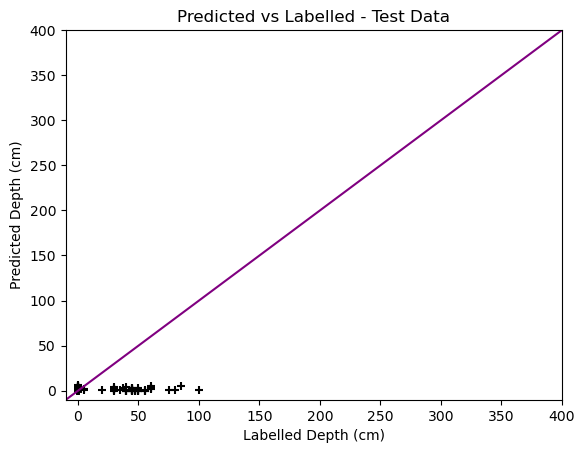

In [18]:
# add a scatter plot of the data points
plt.scatter(y_test, y_pred_test, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Test Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400], c='purple');

In [19]:
# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(y_test, y_pred_test)
print("R Squared:", R_squared)

RMSE = mean_squared_error(y_test, y_pred_test, squared=False)
print("RMSE:", RMSE)

R Squared: -0.29970281447002733
RMSE: 26.457168992465736


In [ ]:
# study the partial dependence between the predicted thickness and predictors 
#from sklearn.inspection import PartialDependenceDisplay
#PartialDependenceDisplay.from_estimator(rf_model, x_train, ['AV_STK_100'])

# Gradient Boosting Machine 

In [ ]:
df

# Neural Net (fastai)

In [31]:
# get data ready for training by specifying what Tabular data loader needs to know 
#   df = dataframe working with
#   splits = indexs used for training and testing
#   procs = pre-processing steps (we don't use categorify and fill missing since already proceessed)
#   cat_names = names of categorical data columns
#   cont_names = names of columns with continuous data
#   y_names = label column name
#   y_block = either CategoryBlock or RegressionBlock depending on target type
dls = TabularPandas(
    df, 
    splits=splits_train_val,
    procs = [Categorify, Normalize],
    cat_names=["CROPTYPE", "Landcover", "MRRTF", "MRVBF", "Soilscapes", "Soiltype",],
    cont_names=['AV_STK_100', 'AV_STK_150', 'AV_STK_30', 'Blue', 'Elevation', 'Green', 'NDMI', 'NDVI', 'NDWI', 'NIR',
                'PALSAR_HH', 'PALSAR_HV', 'PALSAR_Index1', 'PALSAR_Index2', 'PALSAR_Index3', 'REdge1', 'REdge2', 
                'REdge3', 'REdge4', 'Red', 'SWIR1', 'SWIR2', 'Sen1_Index1', 'Sen1_Index2', 'Sen1_Index3', 'Sen1_VH', 
                'Sen1_VV', 'TWI', 'd2_River', 'd2_Watercourse', 'Landcover_conf', 'date'],
    y_names="depth", 
    y_block = RegressionBlock(),
).dataloaders(path=".")

    #cat_names=["CROPTYPE", "Landcover", "MRRTF", "MRVBF", "Soilscapes", "Soiltype",],
    #cont_names=['AV_STK_100', 'AV_STK_150', 'AV_STK_30', 'Blue', 'Elevation', 'Green', 'NDMI', 'NDVI', 'NDWI', 'NIR',
                #'PALSAR_HH', 'PALSAR_HV', 'PALSAR_Index1', 'PALSAR_Index2', 'PALSAR_Index3', 'REdge1', 'REdge2', 
                #'REdge3', 'REdge4', 'Red', 'SWIR1', 'SWIR2', 'Sen1_Index1', 'Sen1_Index2', 'Sen1_Index3', 'Sen1_VH', 
                #'Sen1_VV', 'TWI', 'd2_River', 'd2_Watercourse', 'Landcover_conf', 'date'],

In [32]:
#df.hist(["MRRTF", "Soiltype", "Soilscapes", 'AV_STK_150', 'Elevation', 'date', 'd2_River']);

In [33]:
#test_df.hist(["MRRTF", "Soiltype", "Soilscapes", 'AV_STK_150', 'Elevation', 'date', 'd2_River']);

In [34]:
# Build a learner (model + data)
# we specify the size of each HIDDEN layer (doesn't matter how many inputs we have or outputs, just the main body of model)
learn = tabular_learner(dls, metrics=[rmse, R2Score()], layers=[20,10])

In [35]:
# we never want negative preidictions so add a ReLU to the final layer
learn.model.layers.add_module("ReLU", nn.ReLU(inplace=True))

In [36]:
# to see the exact architecture that fastai specifies when using the TabularLearner function we call learn.model
# we use embeddings, dropout, batchnorm and 2 hidden layers in our network
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(25, 10)
    (1): Embedding(9, 5)
    (2): Embedding(8, 5)
    (3): Embedding(7, 5)
    (4): Embedding(11, 6)
    (5): Embedding(26, 10)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=73, out_features=20, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=20, out_features=10, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=10, out_features=1, bias=True)
    )
    (ReLU): ReLU(inplace=True)
  )
)

In [37]:
#learn.lr_find(suggest_funcs=(slide, valley))

In [38]:
# I'm guessing we need a large learning rate since we have so many features that travessing the space of optimal weights
# takes a long time. When we have done feature selection this won't be so much of a problem
learn.fit(25, lr=0.1)
learn.fit(10, lr=0.01)

epoch,train_loss,valid_loss,_rmse,r2_score,time
0,5953.092773,2855.247070,53.434509,0.353375,00:00
1,4096.534180,2648.504150,51.463619,0.400196,00:00
2,3293.959229,2603.029053,51.019890,0.410494,00:00
3,2770.177490,2090.152588,45.718185,0.526645,00:00
4,2422.368164,2850.616699,53.391167,0.354423,00:00
5,2212.684814,1887.995605,43.451073,0.572427,00:00
6,2006.775269,2387.169434,48.858669,0.459380,00:00
7,1926.932373,1977.855347,44.473087,0.552077,00:00
8,1828.214966,1982.031494,44.520016,0.551131,00:00
9,1695.276855,2014.710205,44.885521,0.543730,00:00


epoch,train_loss,valid_loss,_rmse,r2_score,time
0,1150.083496,1900.076538,43.589863,0.569691,00:00
1,1025.570557,1939.080811,44.035000,0.560858,00:00
2,1057.212402,1952.840698,44.190956,0.557742,00:00
3,1056.665039,1915.843872,43.770355,0.566120,00:00
4,1012.251831,1910.736694,43.711975,0.567277,00:00
5,981.446716,1919.164062,43.808266,0.565369,00:00
6,966.379639,1946.604126,44.120338,0.559154,00:00
7,933.110657,1932.526001,43.960503,0.562343,00:00
8,925.117249,1947.669189,44.132408,0.558913,00:00
9,918.823547,1948.621704,44.143200,0.558697,00:00


R Squared: 0.853496865053785
RMSE: 26.871121351261184


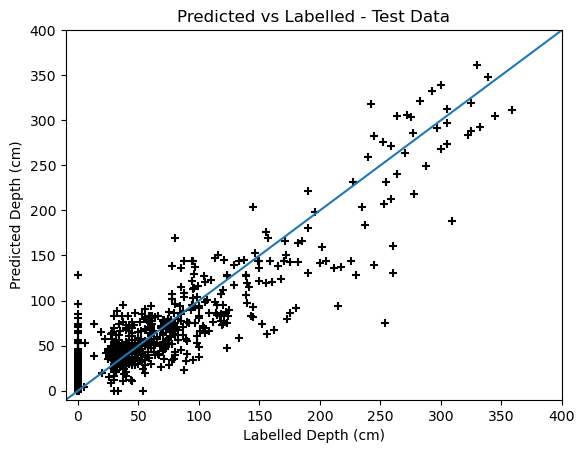

In [39]:
# Use the trained model to get predictions for training dataset
preds_train,_ = learn.get_preds(dl=dls.train)

# plot the predictions and calculate the rmse and R2 score 
plt.scatter(y_train, preds_train, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Test Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400]);

# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(y_train, preds_train)
print("R Squared:", R_squared)

RMSE = mean_squared_error(y_train, preds_train, squared=False)
print("RMSE:", RMSE)

R Squared: 0.5586972981373138
RMSE: 44.14319721948162


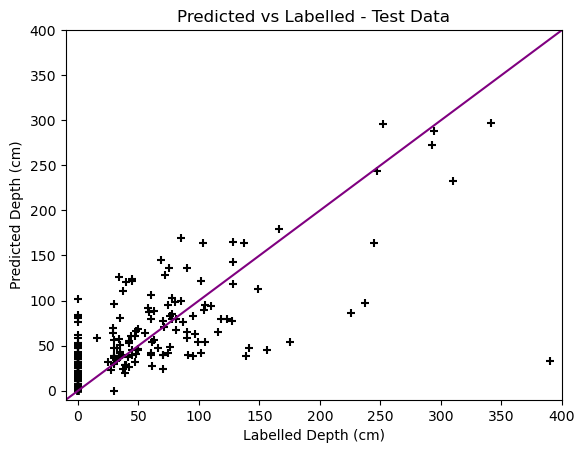

In [40]:
# Use the trained model to get predictions for training dataset
preds_val,_ = learn.get_preds(dl=dls.valid)

# plot the predictions and calculate the rmse and R2 score 
plt.scatter(y_val, preds_val, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Test Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400], c='purple');

# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(y_val, preds_val)
print("R Squared:", R_squared)

RMSE = mean_squared_error(y_val, preds_val, squared=False)
print("RMSE:", RMSE)

In [41]:
# test performance on the holdout dataset

# make sure to do same feature-engineering steps to the test dataset (processing steps stored in learner but want to
# apply to a new dataset so just grab a test_dl object with same transforms stored)
tst_dl = learn.dls.test_dl(test_df)

In [42]:
# get predictions from data loaded in in the correct way
preds,_ = learn.get_preds(dl=tst_dl)

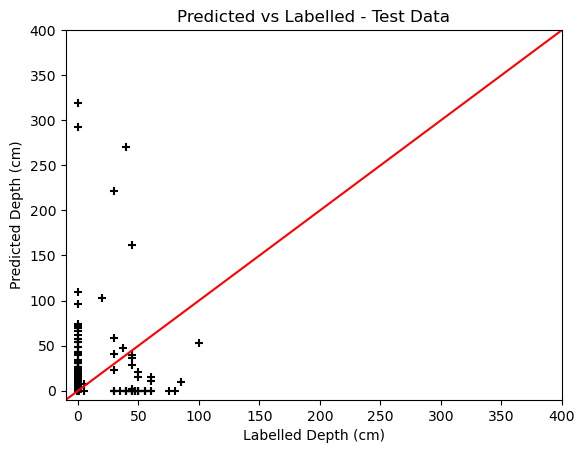

In [43]:
# plot the predictions and calculate the rmse and R2 score 
plt.scatter(y_test, preds, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Test Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400], c='red');

In [44]:
# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(y_test, preds)
print("R Squared:", R_squared)

RMSE = mean_squared_error(y_test, preds, squared=False)
print("RMSE:", RMSE)

R Squared: -4.879554155030924
RMSE: 56.27215394642877


# Ensembling

In [ ]:
# Simplest kind of ensembling is ensembling same kind of model but trained of different subsets of data
# Essentially make a model, fit the model, predict on test set and return predictions 

def ensemble():
    learn = tabular_learner(dls, metrics=[rmse, R2Score()], layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(25, lr=0.1)
    with learn.no_bar(),learn.no_logging(): learn.fit(10, lr=0.01)    
    return learn.get_preds(dl=tst_dl)[0]

In [ ]:
# do this 5 times and store all predictions 
learns = [ensemble() for _ in range(5)]

In [ ]:
ens_preds = torch.stack(learns).mean(0)

In [ ]:
# plot the predictions and calculate the rmse and R2 score 
plt.scatter(y_test, ens_preds, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Test Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400], c='red');

In [ ]:
# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(y_test, ens_preds)
print("R Squared:", R_squared)

RMSE = mean_squared_error(y_test, ens_preds, squared=False)
print("RMSE:", RMSE)

# Embeddings of categories 

We also want to try using embeddings as inputs to the random forests instead of only relying on the assumed numerical relationship bteween categories. Therefor we need a method for generating embeddings of the categorical variables, and then use these to make a new dataframe with the new relevant columns. 

In [ ]:
# we can grab the fitted embeddings from the model that has already been trained (this trains parameters of embedding
# matrix for us)
# We only need to grab the embeddings of the features we actually want to use after our feature selection process 
MRRTF_embedding = learn.model.embeds[2]

Find the embeddings for every row in the train/val dataframe. Make a new dataframe with these embedding vectors appended to the dataframe

In [ ]:
# for each row in dataframe we need to find the value of MRRTF and use this to get the equivalent 
# embedding which should then be added to the dataframe 
mrrtf_data = torch.LongTensor(df['MRRTF'].values)
embedding_vectors = MRRTF_embedding.forward(mrrtf_data).detach()

# make this into a pandas dataframe so that we can join later 
embedding_vectors_df = pd.DataFrame(embedding_vectors.numpy(), index=df.index)
embedding_vectors_df.columns = ['MRRTF_E1', 'MRRTF_E2', 'MRRTF_E3', 'MRRTF_E4', 'MRRTF_E5']

# join the original dataframe with the required embeddings 
df_embed = pd.concat([df, embedding_vectors_df], axis=1)

Need to do the same process to the test dataframe also

In [ ]:
mrrtf_data = torch.LongTensor(test_df['MRRTF'].values)
embedding_vectors = MRRTF_embedding.forward(mrrtf_data).detach()

# make this into a pandas dataframe so that we can join later 
embedding_vectors_df = pd.DataFrame(embedding_vectors.numpy(), index=test_df.index)
embedding_vectors_df.columns = ['MRRTF_E1', 'MRRTF_E2', 'MRRTF_E3', 'MRRTF_E4', 'MRRTF_E5']

# join the original dataframe with the required embeddings 
test_df_embed = pd.concat([test_df, embedding_vectors_df], axis=1)

Split the data into the explicit sub-splits that we need for modelling 

In [ ]:
# for some models we need explicit datasets
x_train_embed = df_embed.iloc[splits_train_val[0],:].drop('depth', axis=1)
y_train_embed = df_embed.iloc[splits_train_val[0],:]['depth']

x_val_embed = df_embed.iloc[splits_train_val[1],:].drop('depth', axis=1)
y_val_embed = df_embed.iloc[splits_train_val[1],:]['depth']

# some models need explicit datasets
x_test_embed = test_df_embed.drop('depth', axis=1)
y_test_embed = test_df_embed['depth']

In [ ]:
# check performance of random forest as a result
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 0, oob_score=True)
 
# fit the random forest to the x and y data (for random forest don't need validation set)
rf_model.fit(pd.concat([x_train_embed, x_val_embed]), pd.concat([y_train_embed, y_val_embed])) 

In [ ]:
# get the feature names from the column headings 
feature_names = [i for i in df_embed.columns]
feature_names.remove('depth')

# look at the feature importances for the model
importances = rf_model.feature_importances_

# place them in a pandas object and re-organise them
forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values().iloc[::-1]

In [ ]:
# plot the feature importances 
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
y_pred_train_val = rf_model.predict(pd.concat([x_train_embed, x_val_embed]))
y_pred_test = rf_model.predict(x_test_embed)

In [ ]:
# add a scatter plot of the data points
plt.scatter(pd.concat([y_train_embed, y_val_embed]), y_pred_train_val, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Training Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400]);

In [ ]:
# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(pd.concat([y_train_embed, y_val_embed]), y_pred_train_val)
print("R Squared:", R_squared)

RMSE = mean_squared_error(pd.concat([y_train_embed, y_val_embed]), y_pred_train_val, squared=False)
print("RMSE:", RMSE)

In [ ]:
# add a scatter plot of the data points
plt.scatter(y_test_embed, y_pred_test, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Test Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400], c='purple');

In [ ]:
# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(y_test_embed, y_pred_test)
print("R Squared:", R_squared)

RMSE = mean_squared_error(y_test_embed, y_pred_test, squared=False)
print("RMSE:", RMSE)